In [1]:

import os

from config import BASE_DIR

from src.baselines.main import make_baselines_results
RERUN = True

In [2]:
def generate_params(n):
    mfw_string = f"MFW={n}"
    NO_PREPROCESSING = []
    WEAK = [mfw_string, "LEMMATIZATION"]
    MEDIUM = [mfw_string, "LEMMATIZATION", "STOPWORDS"]
    STRONG = [mfw_string, "LEMMATIZATION", "STOPWORDS", "LEX"]
    
    params = [("NO_PREPROCESSING", NO_PREPROCESSING), 
              (f"WEAK_{mfw_string}", WEAK), 
              (f"MEDIUM_{mfw_string}", MEDIUM), 
              (f"STRONG_{mfw_string}", STRONG)]
    
    return params
params = generate_params(5)
params.extend(generate_params(10))
params.extend(generate_params(25))
# params.extend(generate_params(50))
params

[('NO_PREPROCESSING', []),
 ('WEAK_MFW=5', ['MFW=5', 'LEMMATIZATION']),
 ('MEDIUM_MFW=5', ['MFW=5', 'LEMMATIZATION', 'STOPWORDS']),
 ('STRONG_MFW=5', ['MFW=5', 'LEMMATIZATION', 'STOPWORDS', 'LEX']),
 ('NO_PREPROCESSING', []),
 ('WEAK_MFW=10', ['MFW=10', 'LEMMATIZATION']),
 ('MEDIUM_MFW=10', ['MFW=10', 'LEMMATIZATION', 'STOPWORDS']),
 ('STRONG_MFW=10', ['MFW=10', 'LEMMATIZATION', 'STOPWORDS', 'LEX']),
 ('NO_PREPROCESSING', []),
 ('WEAK_MFW=25', ['MFW=25', 'LEMMATIZATION']),
 ('MEDIUM_MFW=25', ['MFW=25', 'LEMMATIZATION', 'STOPWORDS']),
 ('STRONG_MFW=25', ['MFW=25', 'LEMMATIZATION', 'STOPWORDS', 'LEX'])]

In [3]:
# params = [("MFW=5", ["MFW=5"]), ("LEMMATIZATION", ["LEMMATIZATION"])]

In [4]:
from datetime import datetime
from tqdm.notebook import tqdm


ALL_EXP_BASE_DIR = f"{BASE_DIR}/dss/experiments/pre_processing"
if RERUN:
    from src.ETL.main_ETL import generate_data    
    for name, pre_processing_tasks in tqdm(params):
        name = f"{name}"
        print(f"{datetime.now()} - {pre_processing_tasks=}")

        exp_name = f"{name}"
        exp_dir = f"{ALL_EXP_BASE_DIR}/{exp_name}"

        if not os.path.exists(exp_dir) or len(os.listdir(exp_dir)) == 0:
            os.makedirs(exp_dir, exist_ok=True)
            df_name = f"{exp_dir}/{exp_name}.csv"
            #creating_data
            tmp_df = generate_data(15, 100,pre_processing_tasks, df_name)
            df_filtered_name = f"{exp_dir}/filtered_{exp_name}.csv"
            #making baselines
            make_baselines_results(data_path=df_filtered_name, processed_vectorizers_path=f"{exp_dir}/{exp_name}.pkl",
                                   results_dir=exp_dir, train_frac=0.7, val_frac=0.1, tasks=["scroll", "composition"])



In [35]:
os.listdir(ALL_EXP_BASE_DIR)

['WEAK_MFW=10',
 'MEDIUM_MFW=5',
 '.DS_Store',
 'WEAK_MFW=5',
 'MEDIUM_MFW=25',
 'STRONG_MFW=10',
 'pre_processing_tuning.py',
 'pre_chunking',
 'WEAK_MFW=25',
 'MEDIUM_MFW=10',
 'STRONG_MFW=25',
 'NO_PREPROCESSING',
 'STRONG_MFW=5']

In [57]:
import re
import os
import pandas as pd

ALL_EXP_BASE_DIR = f"{BASE_DIR}/dss/experiments/pre_processing"
task_types = ["book_supervised", "book_unsupervised", "composition_supervised", "composition_unsupervised"]
book_supervised = []
book_unsupervised = []
composition_supervised = []
composition_unsupervised = []
dataset_sizes = {}
dataset_word_counts = {}
book_counts = {}
composition_counts = {}

for exp in os.listdir(ALL_EXP_BASE_DIR):
    if exp in [".DS_Store", "pre_processing_tuning.py", "pre_chunking"]:
        print(f"aborting {exp}")
        continue
    base = f"{ALL_EXP_BASE_DIR}/{exp}"
    try:
        mfw = int(exp.split("=")[1])
        pre_processing_type = exp.split("=")[0]
    except:
        mfw = "None"
        pre_processing_type = exp
    # Read the filtered dataset to get its size, word count, and unique counts
    filtered_df = pd.read_csv(f"{base}/filtered_{exp}.csv")
    
        
    dataset_sizes[exp] = len(filtered_df)
    dataset_word_counts[exp] = filtered_df['text'].str.split().str.len().sum()
    book_counts[exp] = filtered_df['book'].nunique()
    composition_counts[exp] = filtered_df['composition'].nunique()
    for task in task_types:
        tmp_df = pd.read_csv(f"{base}/{task}.csv")
        tmp_df['method'] = exp
        tmp_df['dataset_size'] = dataset_sizes[exp]
        tmp_df['word_count'] = dataset_word_counts[exp]
        tmp_df['scroll_count'] = book_counts[exp]
        tmp_df["mfw"] = mfw
        tmp_df["pre_processing_type"] = pre_processing_type
        tmp_df["avg_word_count_in_chunk"] = tmp_df["word_count"] / tmp_df["dataset_size"]
        if task == "book_supervised":
            book_supervised.append(tmp_df)
        elif task == "book_unsupervised":
            book_unsupervised.append(tmp_df)
        elif task == "composition_supervised":
            composition_supervised.append(tmp_df)
        elif task == "composition_unsupervised":
            composition_unsupervised.append(tmp_df)


df_book_supervised = pd.concat(book_supervised)
df_book_unsupervised = pd.concat(book_unsupervised)
df_composition_supervised = pd.concat(composition_supervised)
df_composition_unsupervised = pd.concat(composition_unsupervised)

# Print dataset sizes, word counts, and unique counts for each method
# for method in dataset_sizes.keys():
#     print(f"Dataset size for {method}: {dataset_sizes[method]}")
#     print(f"Word count for {method}: {dataset_word_counts[method]}")
#     print(f"Unique book count for {method}: {book_counts[method]}")
#     print(f"Unique composition count for {method}: {composition_counts[method]}")
#     print("\n")


aborting .DS_Store
aborting pre_processing_tuning.py
aborting pre_chunking


In [58]:
datasets_stats = pd.DataFrame([dataset_sizes, dataset_word_counts, composition_counts, book_counts], index=["dataset_sizes", "dataset_word_counts", "composition", "book"]).T.sort_values(by="book", ascending=False)

datasets_stats["avg_word_count_in_chunk"] = datasets_stats["dataset_word_counts"] / datasets_stats["dataset_sizes"]
datasets_stats.rename(columns={"composition":"n_compositions", "book":"n_scrolls"}).sort_values(by="dataset_word_counts",
                                                                                               ascending=False)

,dataset_sizes,dataset_word_counts,n_compositions,n_scrolls,avg_word_count_in_chunk
NO_PREPROCESSING,1420,100831,56,129,71.007746
WEAK_MFW=5,1420,96766,56,129,68.145070
WEAK_MFW=10,1420,92668,56,129,65.259155
LEX,1420,86135,56,129,60.658451
WEAK_MFW=25,1420,81490,56,129,57.387324
MEDIUM_MFW=5,1420,61155,56,129,43.066901
MEDIUM_MFW=10,1420,60667,56,129,42.723239
STRONG_MFW=5,1420,59160,56,129,41.661972
STRONG_MFW=10,1420,58668,56,129,41.315493
MEDIUM_MFW=25,1420,54183,56,129,38.157042


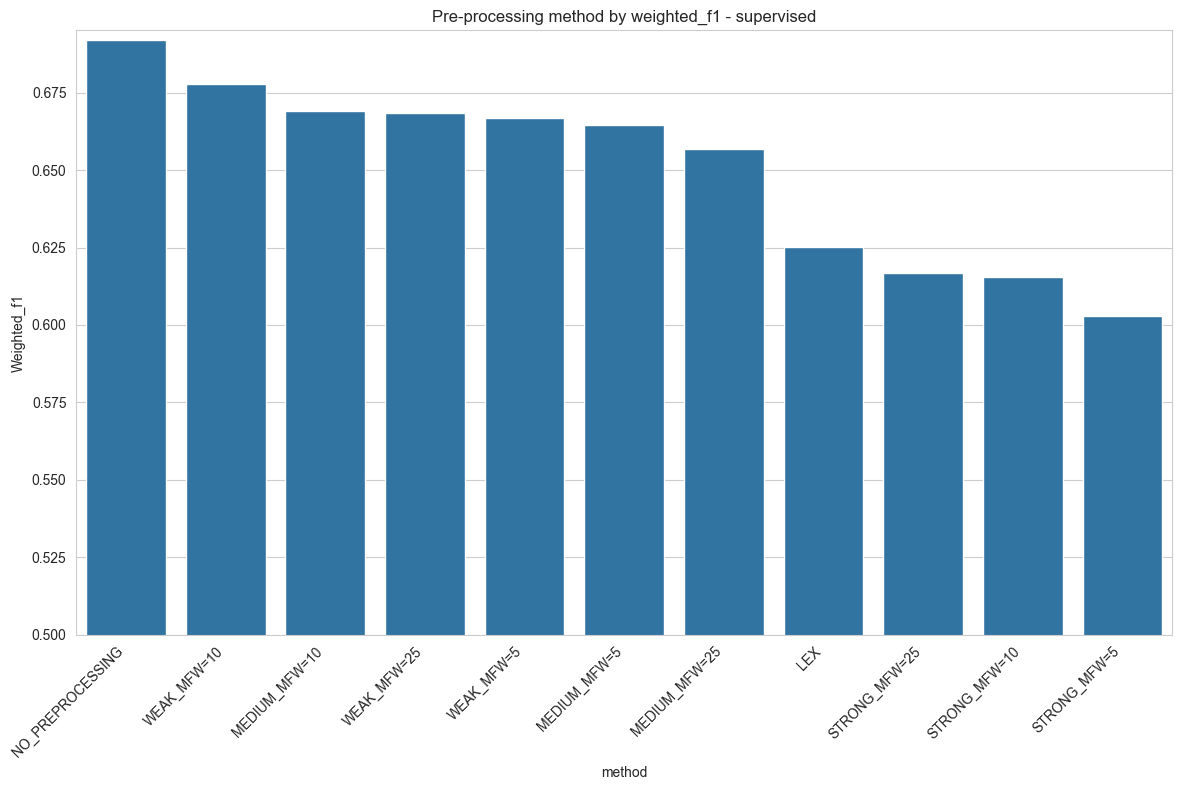

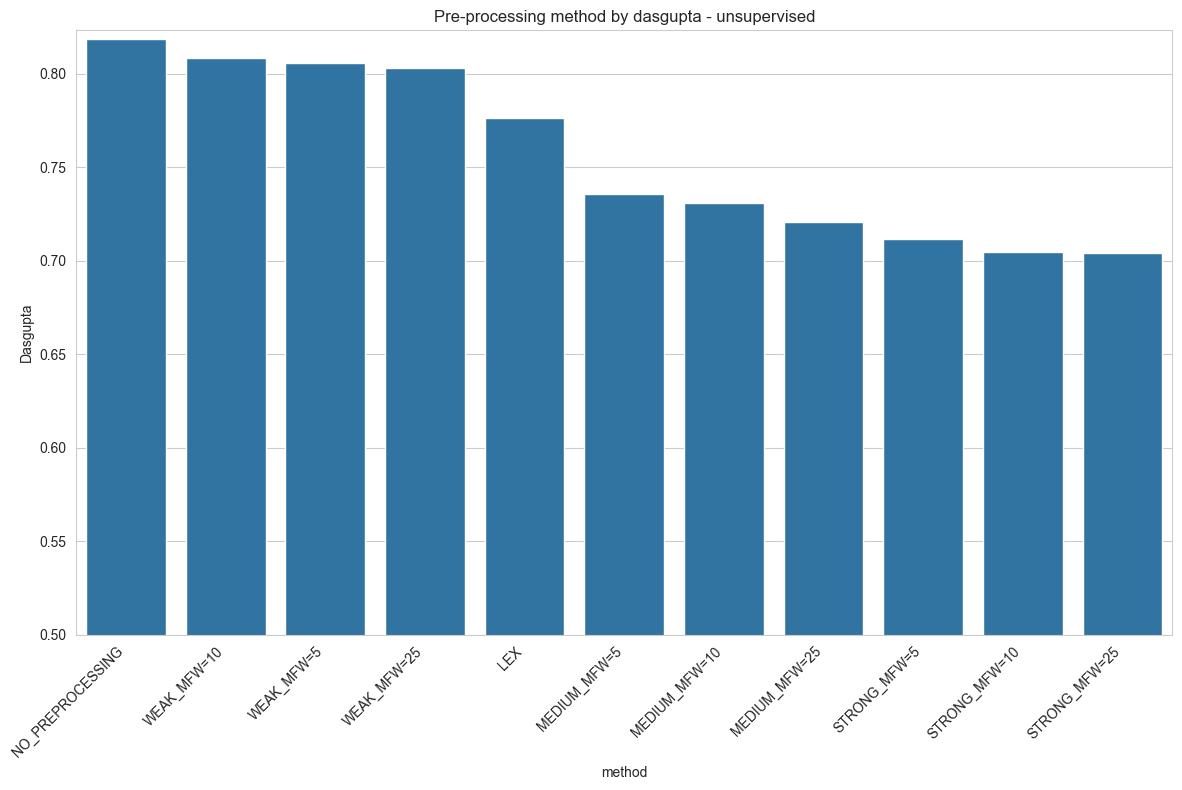

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

results = {
    "book_supervised": df_book_supervised,
    "book_unsupervised": df_book_unsupervised,
    "composition_supervised": df_composition_supervised,
    "composition_unsupervised": df_composition_unsupervised
}

results = {"supervised": pd.concat([df_book_supervised, df_composition_supervised]),
           "unsupervised": pd.concat([df_book_unsupervised, df_composition_unsupervised]),
           }

def plot_results(name, df_res,x):
    
    is_unsupervised = "unsupervised" in name
    metric = "dasgupta" if is_unsupervised else "weighted_f1"
    vec_type = "vectorizer_type" if is_unsupervised else "vectorizer"

    # df_res = df_res.groupby([x, vec_type])[metric].max().reset_index()
    df_res = df_res.groupby([x])[metric].max().reset_index()
    
    # Sort methods by median values
    median_values = df_res.groupby(x)[metric].mean().sort_values(ascending=False)
    order = median_values.index.tolist()

    plt.figure(figsize=(12, 8))

    # sns.boxplot(data=df_res, x=x, y=metric, showmeans=True, showfliers=True, order=order)
    sns.barplot(data=df_res, x=x, y=metric, order=order)
    plt.title(f"Pre-processing method by {metric} - {name}")
    plt.xlabel(x)
    plt.ylabel(metric.capitalize())
    plt.xticks(rotation=45, ha="right")
    std = df_res[metric].std()
    # plt.ylim(df_res[metric].min()+0.1*std, df_res[metric].max()-std*0.1)
    plt.ylim(0.5, df_res[metric].max()+std*0.1)
    plt.tight_layout()
    plt.show()

for name, df_res in results.items():
    plot_results(name, df_res, "method")

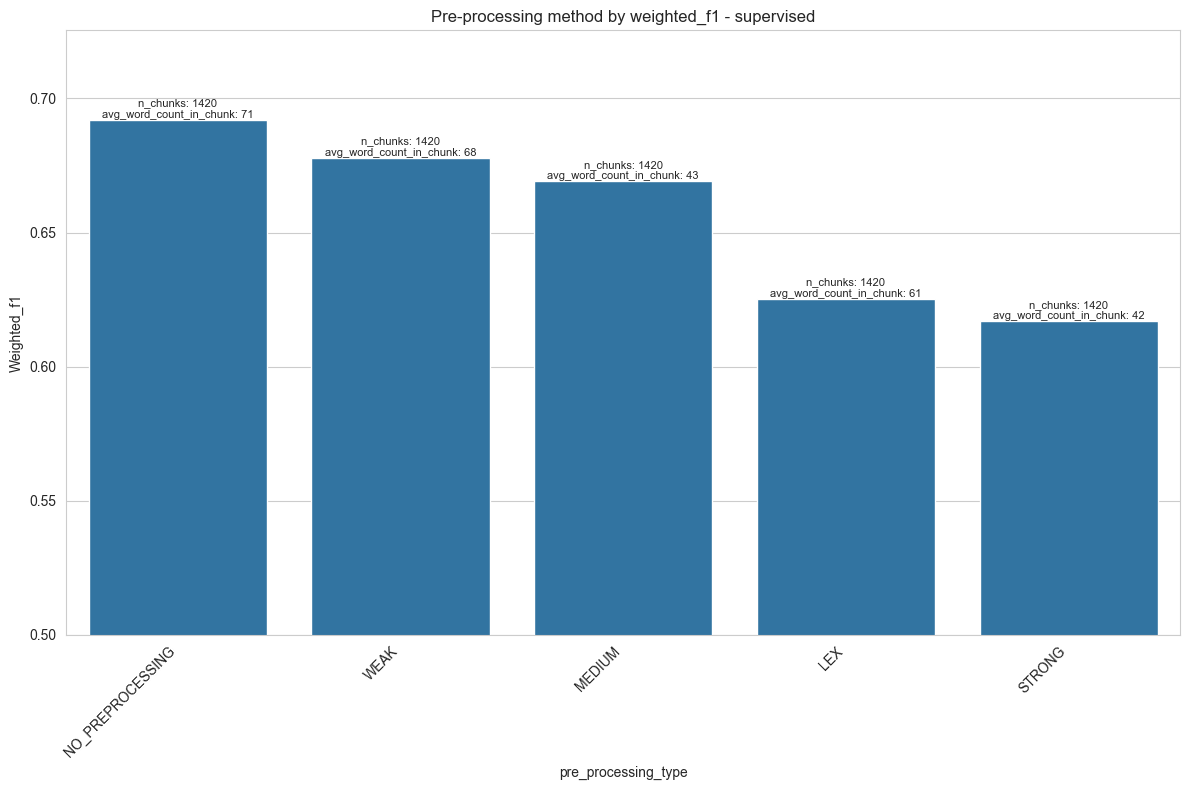

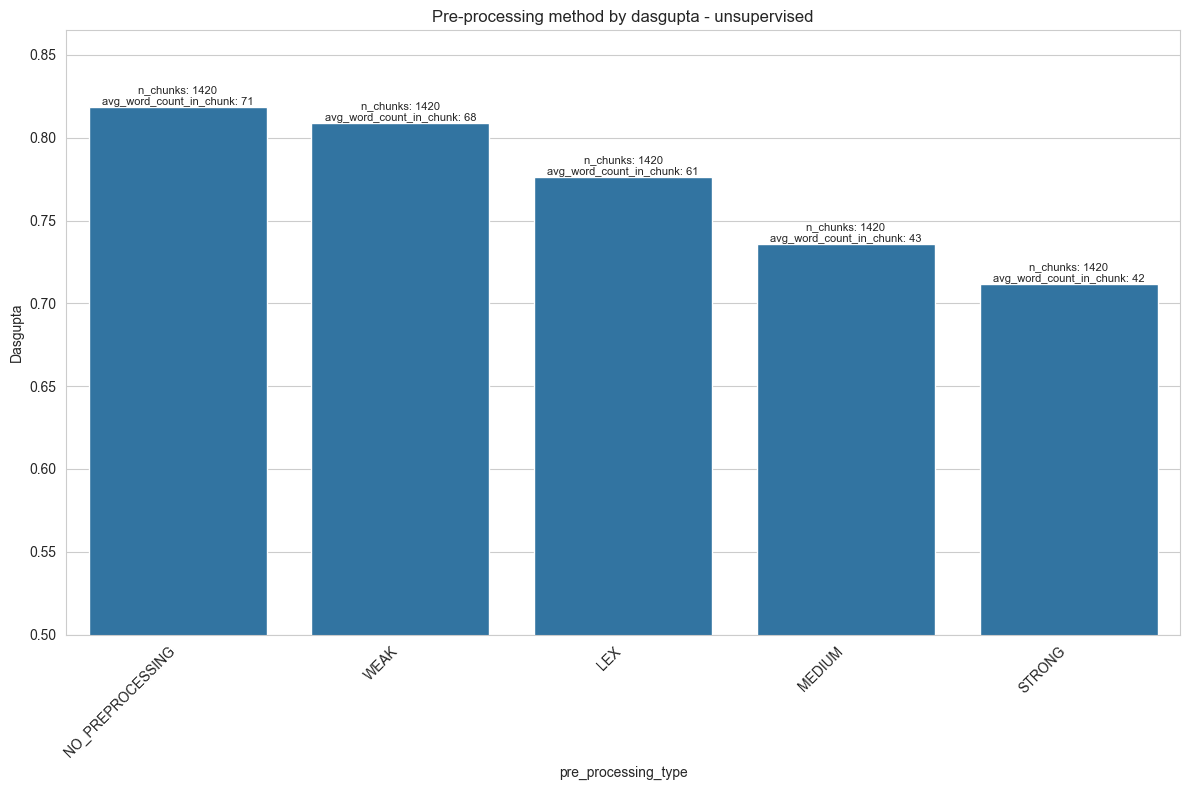

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def plot_results(name, df_res, x):
    is_unsupervised = "unsupervised" in name
    metric = "dasgupta" if is_unsupervised else "weighted_f1"
    
    # Group by and calculate mean for metric, dataset_size, and scroll_count
    df_res = df_res.groupby([x]).agg({
        metric: 'max',
        'dataset_size': 'max',
        'avg_word_count_in_chunk': 'max'
    }).reset_index()
    df_res[x] = df_res[x].replace({"WEAK_MFW":"WEAK", "STRONG_MFW":"STRONG", "MEDIUM_MFW":"MEDIUM"})
    # Sort methods by median values
    df_res = df_res.sort_values(by=metric, ascending=False)
    order = df_res[x].tolist()

    plt.figure(figsize=(12, 8))
    ax = sns.barplot(data=df_res, x=x, y=metric, order=order)
    
    plt.title(f"Pre-processing method by {metric} - {name}")
    plt.xlabel(x)
    plt.ylabel(metric.capitalize())
    plt.xticks(rotation=45, ha="right")

    std = df_res[metric].std()
    plt.ylim(0.5, df_res[metric].max() + std)

    # Add text annotations to the bars
    for i, (index, row) in enumerate(df_res.iterrows()):
        height = row[metric]
        dataset_size = row['dataset_size']
        avg_word_count_in_chunk = row['avg_word_count_in_chunk']
        
        ax.text(
            i,  # Use the index of the bar
            height,
            f'n_chunks: {dataset_size:.0f}\navg_word_count_in_chunk: {avg_word_count_in_chunk:.0f}',
            ha='center',
            va='bottom',
            fontsize=8
        )

    plt.tight_layout()
    plt.show()

# Use the function as before
for name, df_res in results.items():
    plot_results(name, df_res, "pre_processing_type")